In [40]:
from simulator import Sim
from strategy import BestPosStrategy
from get_info import get_pnl
from load_data import load_md_from_file

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
from typing import List, Optional, Tuple, Union, Dict
import math
from simulator import MdUpdate, Order, OwnTrade, Sim, update_best_positions
import bisect
import seaborn as sns
from collections import defaultdict, deque

In [2]:
"""
    Load data
"""

Tsmall = pd.Timedelta(20, 'm').delta
T6h = pd.Timedelta(6, 'h').delta
Tlrg = pd.Timedelta(25, 'h').delta
PATH_TO_FILE = '../md/btcusdt_Binance_LinearPerpetual/'

md_small = load_md_from_file(path=PATH_TO_FILE, T = Tsmall)
md_6h = load_md_from_file(path=PATH_TO_FILE, T = T6h)
md_large = load_md_from_file(path=PATH_TO_FILE, T = Tlrg)

In [93]:
class Observer:
    def __init__(self, cp_scale = 10, memory_sec = 60 * 60) -> None:
        self.cp_scale = cp_scale
        self.memory_sec = memory_sec
        self.memory = pd.Timedelta(memory_sec, 's').delta
        
        self.tick = 0.1
        self.ups = deque()
        self.downs = deque()
        self.changed = deque()
        self.last_ob = None
        self.eps = 0.00001
        self.active = False
        
        
    def is_up(self, orderbook):
        if not self.last_ob:
            return False
        if orderbook.asks[0][0] + orderbook.bids[0][0] > self.last_ob.asks[0][0] + self.last_ob.bids[0][0] + self.eps:
            return True
    
    
    def is_down(self, orderbook):
        if not self.last_ob:
            return False
        if orderbook.asks[0][0] + orderbook.bids[0][0] < self.last_ob.asks[0][0] + self.last_ob.bids[0][0] - self.eps:
            return True
    
    
    def clean_old(self, orderbook):
        while len(self.ups) and orderbook.receive_ts - self.memory > self.ups[0][0]:
            self.ups.popleft()
        
        while len(self.downs) and orderbook.receive_ts - self.memory > self.downs[0][0]:
            self.downs.popleft()
        
        while len(self.changed) and orderbook.receive_ts - self.memory > self.changed[0][0]:
            self.changed.popleft()
            self.active = True
    
    
    def update(self, orderbook):
        if self.is_up(orderbook):
            self.ups.append((orderbook.receive_ts, 1))
        
        if self.is_down(orderbook):
            self.downs.append((orderbook.receive_ts, 1))
        
        if self.is_up(orderbook) or self.is_down(orderbook):
            self.changed.append((orderbook.receive_ts, 1))
        
        self.clean_old(orderbook)
        self.last_ob = orderbook
        
        
    def pi_up(self):
        ct_up, ct_down = len(self.ups), len(self.downs)
        exp_stay_inv = len(self.changed) / self.memory_sec
        
        return ct_up / (ct_up + ct_down) * exp_stay_inv
    
    
    def pi_down(self):
        ct_up, ct_down = len(self.ups), len(self.downs)
        exp_stay_inv = len(self.changed) / self.memory_sec
        
        return ct_down / (ct_up + ct_down) * exp_stay_inv
    
    
    def cp_jp(self):
        if not self.active:
            return 0
        return (self.pi_up() - self.pi_down()) * self.tick
    
    def cp_bvol(self):
        if not self.last_ob:
            return 0        

        exp_stay_inv = len(self.changed) / self.memory_sec
        va = self.last_ob.asks[0][1]
        vb = self.last_ob.bids[0][1]
        
        up = vb / (va + vb)
        down = va / (va + vb)
        
        return (up - down) * exp_stay_inv * self.tick
    
    def get_cp(self, t = 'none'):
        if t == 'jump_process':
            return self.cp_jp() * self.cp_scale
        if t == 'best_volumes':
            return self.cp_bvol() * self.cp_scale
        return 0

In [103]:
class BestLimit:
    def __init__(self, delay_orders, thr_one_side, thr_market, predictor_type) -> None:
        # init logger
        self.observer = Observer()
        
        # hyper-parameters
        self.delay_orders = delay_orders
        self.lim1 = thr_one_side
        self.lim2 = thr_market
        self.predictor_type = predictor_type
        
        # parameters
        self.order_size = 0.001
        self.q = 0
        self.last_order_ts = 0
        
        # constants
        self.INF = 10 ** 9
        self.NO_ORDER = 10 ** 9
        self.MARKET_ORDER = 2 * self.NO_ORDER 
        
        # statistics
        self.ask_vol = 0
        self.bid_vol = 0

        
    def ask_bid(self, last_ob):
        best_ask, best_bid = last_ob.asks[0][0], last_ob.bids[0][0]
        center = self.observer.get_cp(self.predictor_type)
        
        # DARK RED. Market order at ASK.
        if self.q - center >= self.lim2 and self.q > 0:
            price_ask = self.MARKET_ORDER
            price_bid = self.NO_ORDER
            
        # LIGHT RED. Only limit order at ASK
        elif self.q - center >= self.lim1:
            price_ask = best_ask
            price_bid = self.NO_ORDER
        
        # WHITE. Limit orders at ASK and BID.
        elif self.q - center > -self.lim1:
            price_ask = best_ask
            price_bid = best_bid
        
        # LIGHT GREEN. Only limit order at BID
        elif self.q - center > -self.lim2 or self.q >= 0:
            price_ask = self.NO_ORDER
            price_bid = best_bid
        
        # DARK GREEN. Market order at BID
        else:
            price_ask = self.NO_ORDER
            price_bid = self.MARKET_ORDER
                
        return price_ask, price_bid
    
    
    def place_ask(self, receive_ts, order_size, ask):
        ask_order = sim.place_order(receive_ts, order_size, 'ASK', ask)
        self.ongoing_orders[ask_order.order_id] = ask_order

    
    def place_bid(self, receive_ts, order_size, bid):
        bid_order = sim.place_order(receive_ts, order_size, 'BID', bid)
        self.ongoing_orders[bid_order.order_id] = bid_order
        
    
    def do_trade(self, receive_ts, last_ob):
        if not last_ob:
            return
        self.last_order_ts = receive_ts

        # cancel current limit orders
        for ID, order in list(self.ongoing_orders.items()):
            sim.cancel_order(receive_ts, ID)
            self.ongoing_orders.pop(ID)

        # place new orders on current reservation price and spread
        ask, bid = self.ask_bid(last_ob)
        
        if ask == self.MARKET_ORDER:
            ask = -self.INF
            available_volume = last_ob.bids[0][1]
            volume = min(self.q, available_volume)
            
            self.place_ask(receive_ts, volume, ask)
        elif ask != self.NO_ORDER:
            self.place_ask(receive_ts, self.order_size, ask)
        
        if bid == self.MARKET_ORDER:
            bid = self.INF
            available_volume = last_ob.asks[0][1]
            volume = min(-self.q, available_volume)
            
            self.place_bid(receive_ts, volume, bid)
        elif bid != self.NO_ORDER:
            self.place_bid(receive_ts, self.order_size, bid)
            

    def run(self, sim: Sim) -> List[Union[OwnTrade, MdUpdate]]:
        updates_list = []
        cps = []
        last_ob = None
        self.ongoing_orders: Dict[int, Order] = {}
        
        while True:
            receive_ts, updates = sim.tick()
            if updates is None: break
            updates_list += updates
            
            for update in updates:
                if isinstance(update, MdUpdate):
                    if update.orderbook:
                        last_ob = update.orderbook
                        self.observer.update(last_ob)
                        
                        cp = self.observer.get_cp(self.predictor_type)
                        cps.append((receive_ts, cp))
                    
                elif isinstance(update, OwnTrade):
                    if update.side == 'ASK':
                        self.q -= update.size
                        self.ask_vol += update.size
                        
                    if update.side == 'BID':
                        self.q += update.size
                        self.bid_vol += update.size
                    
                    if update.order_id in self.ongoing_orders.keys():
                        self.ongoing_orders.pop(update.order_id)
                        
                    # we want to place a new order, when old one is executed
                    # if we remove this condition, it executes too often and slow
                    if receive_ts - self.last_order_ts >= 0.1 * self.delay_orders:
                        self.do_trade(receive_ts, last_ob)
                else:
                    assert False, 'invalid type of update!'
            
            if receive_ts - self.last_order_ts >= self.delay_orders:
                self.do_trade(receive_ts, last_ob)
                
        return updates_list, cps

In [4]:
"""
    Old sharpe
"""

def get_sharpe(worth_list):
    pnl = worth_list[-1] - worth_list[0]
    aver_dpnl = pnl / (len(worth_list) - 1)
    var_dpnl = 0

    for i in range(len(worth_list) - 1):
        dpnl = worth_list[i + 1] - worth_list[i]
        var_dpnl += (dpnl - aver_dpnl) ** 2

    # no trades and pnl zero everywhere
    if var_dpnl < 0.000001:
        return -1, 0, 0
    
    sigma_dpnl = math.sqrt(var_dpnl / (len(worth_list) - 1))
    sharpe = pnl / sigma_dpnl
    
    return sharpe, pnl, sigma_dpnl

In [113]:
"""
    Convinient to change sizes of dataset
"""

md_run = md_large
# md_run = md_6h
# md_run = md_small

In [114]:
"""
    Running the strategy
"""

parameters = [{'delay_orders': 0.1, 'thr_one_side': 1, 'thr_market': 2, 'predictor_type': 'none'}, 
              {'delay_orders': 0.1, 'thr_one_side': 1, 'thr_market': 2, 'predictor_type': 'jump_process'}]
pnl_xs, pnl_ys, inv_xs, inv_ys = [], [], [], []
all_cps = []


for param in parameters:
    latency = pd.Timedelta(10, 'ms').delta
    sim = Sim(md_run, latency, latency)

    strategy = BestLimit(delay_orders = param['delay_orders'], 
                         thr_one_side = param['thr_one_side'],
                         thr_market = param['thr_market'], 
                         predictor_type = param['predictor_type'])
    print('\nRunning: ', param)

    updates_list, cps = strategy.run(sim)
    receive_ts, worth_list, btc_pos_list, mid_price_list = get_pnl(updates_list)

    # Print statistics 
    sharpe, pnl, volatility = get_sharpe(worth_list)

    print('Final PNL:', pnl)
    print('Volatility of pnl:', volatility)
    print('Sharpe ratio:', sharpe)
    print('Volume ask', strategy.ask_vol)
    print('Volume bid', strategy.bid_vol)

    # save stats for plots
    dt = pd.to_datetime(receive_ts)
    pnl_xs.append(dt)
    pnl_ys.append(worth_list)

    inv_xs.append(dt)
    inv_ys.append(btc_pos_list)
    
    all_cps.append(cps)


Running:  {'delay_orders': 0.1, 'thr_one_side': 1, 'thr_market': 2, 'predictor_type': 'none'}
Final PNL: -1455.9026999996058
Volatility of pnl: 0.17884431797370334
Sharpe ratio: -8140.6147899743555
Volume ask 781.1289999884407
Volume bid 780.478999988456

Running:  {'delay_orders': 0.1, 'thr_one_side': 1, 'thr_market': 2, 'predictor_type': 'jump_process'}
Final PNL: -1464.5481999989333
Volatility of pnl: 0.17680703093238445
Sharpe ratio: -8283.314256654274
Volume ask 780.4179999884575
Volume bid 779.6199999884764


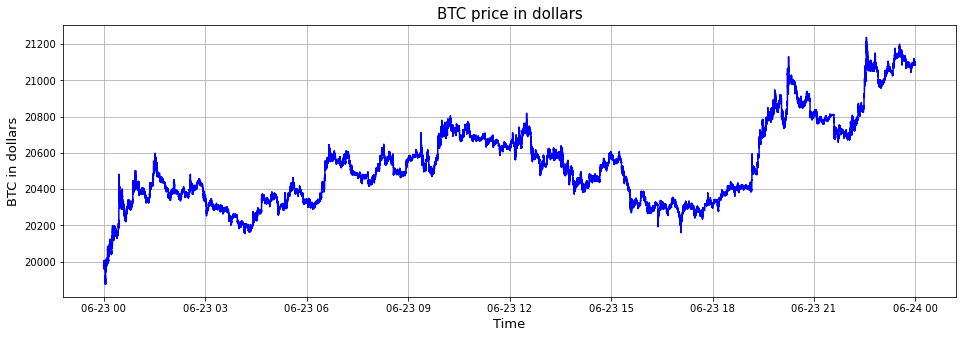

In [115]:
"""
    Plot BTC price 
"""

crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm']
plt.figure(figsize=(16, 5))
plt.plot(dt, mid_price_list, '-', color = crs[2])

plt.xlabel("Time", fontsize=13)
plt.ylabel("BTC in dollars", fontsize=13)
plt.title("BTC price in dollars", fontsize=15)

# plt.legend(loc='lower left')
plt.grid()
plt.show()

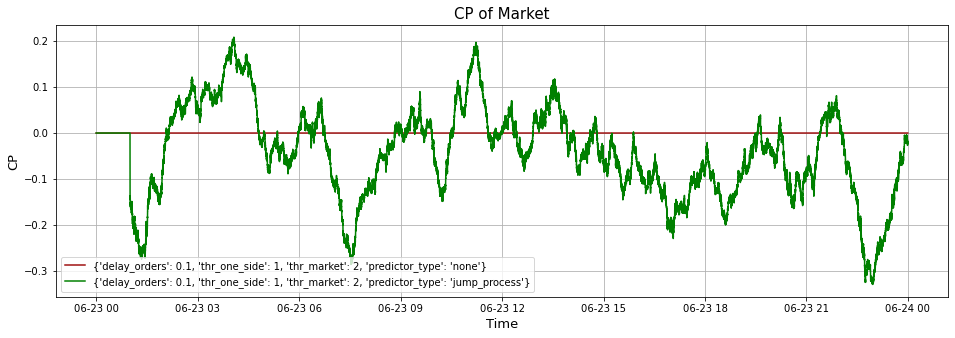

In [116]:
"""
    Plot CP 
"""

crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm']
plt.figure(figsize=(16, 5))
for i, param in enumerate(parameters):
    receive_ts, ys = zip(*all_cps[i])
    xs = pd.to_datetime(receive_ts)
    plt.plot(xs, ys, '-', color = crs[i], label = str(param))

plt.xlabel("Time", fontsize=13)
plt.ylabel("CP", fontsize=13)
plt.title("CP of Market", fontsize=15)

plt.legend(loc='lower left')
plt.grid()
plt.show()

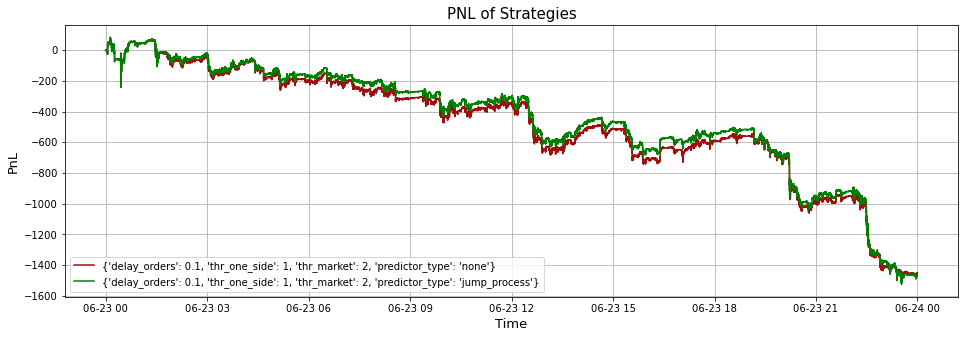

In [117]:
"""
    Plot pnl
"""

crs = ['#9f0f0f', 'g', 'b', 'y', 'c', 'gray', 'm']
plt.figure(figsize=(16, 5))
for i, param in enumerate(parameters):
    plt.plot(pnl_xs[i], pnl_ys[i], '-', color = crs[i], label = str(param))

plt.xlabel("Time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("PNL of Strategies", fontsize=15)

plt.legend(loc='lower left')
plt.grid()
plt.show()

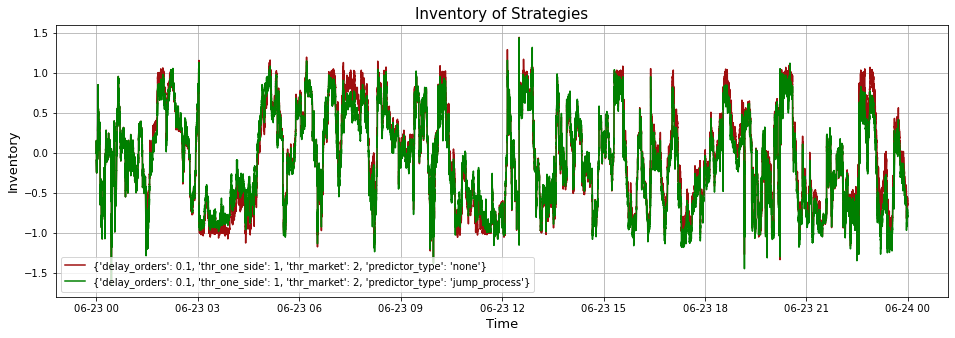

In [118]:
plt.figure(figsize=(16, 5))
for i, param in enumerate(parameters):
    plt.plot(inv_xs[i], inv_ys[i], '-', color = crs[i], label = str(param))

plt.xlabel("Time", fontsize=13)
plt.ylabel("Inventory", fontsize=13)
plt.title("Inventory of Strategies", fontsize=15)

plt.legend(loc='lower left')
plt.grid()
plt.show()